In [46]:
import os

DATASET_PATH = "/kaggle/input"

for root, dirs, files in os.walk(DATASET_PATH):
    print(root)
    for f in files:
        print("  ", f)


/kaggle/input
/kaggle/input/graph-data
   mappings.pt
   graph_data.pt


In [44]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -q


In [47]:
import torch

GRAPH_PATH = "/kaggle/input/graph-data/graph_data.pt"
MAP_PATH   = "/kaggle/input/graph-data/mappings.pt"

data = torch.load(GRAPH_PATH, weights_only=False)
mappings = torch.load(MAP_PATH, weights_only=False)

# CRITICAL: remove string fields
if 'node_id' in data['patient']:
    del data['patient'].node_id
if 'node_id' in data['concept']:
    del data['concept'].node_id

print("Graph loaded successfully")
print(data)


Graph loaded successfully
HeteroData(
  concept={ x=[1488335, 64] },
  patient={ x=[32461, 64] },
  (patient, diagnosed, concept)={ edge_index=[2, 1518499] },
  (concept, rev_diagnosed, patient)={ edge_index=[2, 1518499] },
  (patient, prescribed, concept)={ edge_index=[2, 12322807] },
  (concept, rev_prescribed, patient)={ edge_index=[2, 12322807] },
  (concept, is_a, concept)={ edge_index=[2, 2647386] },
  (concept, equivalent, concept)={ edge_index=[2, 108492] },
  (concept, has_ingredient, concept)={ edge_index=[2, 639735] },
  (concept, prevents, concept)={ edge_index=[2, 2475] },
  (concept, treats, concept)={ edge_index=[2, 15437] },
  (concept, contraindicates, concept)={ edge_index=[2, 12112] },
  (concept, related_to, concept)={ edge_index=[2, 3278] },
  (concept, causes, concept)={ edge_index=[2, 49645] }
)


In [48]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
print("GPU name:", torch.cuda.get_device_name(0) if device.type == 'cuda' else "CPU")


Using device: cuda
GPU name: Tesla P100-PCIE-16GB


In [49]:
import time
import torch
import torch.nn.functional as F
import numpy as np

from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import HGTConv

from sklearn.metrics import roc_auc_score


In [50]:
print("Starting RandomLinkSplit...")

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=True,
    edge_types=[('patient', 'prescribed', 'concept')],
    rev_edge_types=[('concept', 'rev_prescribed', 'patient')],
)

train_data, val_data, test_data = transform(data)

print("Split complete")
print("Train edges:",
      train_data['patient','prescribed','concept'].edge_label_index.size(1))
print("Val edges:",
      val_data['patient','prescribed','concept'].edge_label_index.size(1))
print("Test edges:",
      test_data['patient','prescribed','concept'].edge_label_index.size(1))


Starting RandomLinkSplit...
Split complete
Train edges: 19716494
Val edges: 2464560
Test edges: 2464560


In [51]:
train_loader = LinkNeighborLoader(
    data=train_data,
    edge_label_index=(
        ('patient','prescribed','concept'),
        train_data['patient','prescribed','concept'].edge_label_index
    ),
    edge_label=train_data['patient','prescribed','concept'].edge_label,
    num_neighbors=[10, 10],
    batch_size=512,
    shuffle=True,
)

val_loader = LinkNeighborLoader(
    data=val_data,
    edge_label_index=(
        ('patient','prescribed','concept'),
        val_data['patient','prescribed','concept'].edge_label_index
    ),
    edge_label=val_data['patient','prescribed','concept'].edge_label,
    num_neighbors=[10, 10],
    batch_size=512,
    shuffle=False,
)

print("Loaders ready")
print("Train batches per epoch:", len(train_loader))
print("Val batches:", len(val_loader))


Loaders ready
Train batches per epoch: 38509
Val batches: 4814


In [52]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers, metadata, data):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in metadata[0]:
            in_channels = data[node_type].x.size(-1)
            self.lin_dict[node_type] = torch.nn.Linear(
                in_channels, hidden_channels
            )

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                HGTConv(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    metadata=metadata,
                    heads=num_heads
                )
            )

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            k: self.lin_dict[k](v)
            for k, v in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict


In [53]:
class HGTLinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels, metadata, data):
        super().__init__()
        self.encoder = HGT(
            hidden_channels=hidden_channels,
            num_heads=2,
            num_layers=2,
            metadata=metadata,
            data=data
        )

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        src, dst = edge_label_index
        return (z_dict['patient'][src] *
                z_dict['concept'][dst]).sum(dim=1)


In [54]:
model = HGTLinkPredictor(
    hidden_channels=64,
    metadata=data.metadata(),
    data=data
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("HGT model initialized on", device)


HGT model initialized on cuda


In [55]:
def train(epoch, max_batches=None):
    model.train()
    total_loss = 0.0
    start = time.time()

    for step, batch in enumerate(train_loader, start=1):
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        )

        target = batch['patient','prescribed','concept'].edge_label.float()
        loss = F.binary_cross_entropy_with_logits(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 10 == 0:
            print(
                f"Epoch {epoch} | Batch {step}/{len(train_loader)} | "
                f"Loss {loss.item():.4f} | "
                f"Elapsed {time.time() - start:.1f}s"
            )

        if max_batches and step >= max_batches:
            break

    return total_loss / step


In [56]:
@torch.no_grad()
def test(loader, max_batches=None):
    model.eval()
    preds, targets = [], []

    for step, batch in enumerate(loader, start=1):
        batch = batch.to(device)

        out = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        ).sigmoid()

        preds.append(out.cpu())
        targets.append(batch['patient','prescribed','concept'].edge_label.cpu())

        if max_batches and step >= max_batches:
            break

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    if len(np.unique(targets)) < 2:
        return float("nan")

    return roc_auc_score(targets, preds)


In [58]:
print("Starting HGT training (debug run)")

for epoch in range(1, 3):
    loss = train(epoch, max_batches=200)
    train_auc = test(train_loader, max_batches=50)
    val_auc = test(val_loader, max_batches=50)

    print(
        f"Epoch {epoch} DONE | "
        f"Loss {loss:.4f} | "
        f"Train AUC {train_auc:.4f} | "
        f"Val AUC {val_auc:.4f}"
    )


Starting HGT training (debug run)
Epoch 1 | Batch 10/38509 | Loss 0.0225 | Elapsed 4.5s
Epoch 1 | Batch 20/38509 | Loss 0.0120 | Elapsed 7.0s
Epoch 1 | Batch 30/38509 | Loss 0.0110 | Elapsed 9.4s
Epoch 1 | Batch 40/38509 | Loss 0.0029 | Elapsed 11.9s
Epoch 1 | Batch 50/38509 | Loss 0.0035 | Elapsed 14.4s
Epoch 1 | Batch 60/38509 | Loss 0.0112 | Elapsed 16.9s
Epoch 1 | Batch 70/38509 | Loss 0.0364 | Elapsed 19.3s
Epoch 1 | Batch 80/38509 | Loss 0.0227 | Elapsed 21.9s
Epoch 1 | Batch 90/38509 | Loss 0.0271 | Elapsed 24.3s
Epoch 1 | Batch 100/38509 | Loss 0.0343 | Elapsed 26.8s
Epoch 1 | Batch 110/38509 | Loss 0.0141 | Elapsed 29.2s
Epoch 1 | Batch 120/38509 | Loss 0.0017 | Elapsed 31.7s
Epoch 1 | Batch 130/38509 | Loss 0.0267 | Elapsed 34.2s
Epoch 1 | Batch 140/38509 | Loss 0.0667 | Elapsed 36.6s
Epoch 1 | Batch 150/38509 | Loss 0.0126 | Elapsed 39.2s
Epoch 1 | Batch 160/38509 | Loss 0.0193 | Elapsed 41.6s
Epoch 1 | Batch 170/38509 | Loss 0.0023 | Elapsed 44.1s
Epoch 1 | Batch 180/38509 

In [66]:

import torch
drug_concept_indices = torch.unique(
    train_data['patient', 'prescribed', 'concept'].edge_index[1]
)

drug_concept_indices = drug_concept_indices.cpu()

print("Number of drug concepts:", drug_concept_indices.numel())


Number of drug concepts: 9443


In [67]:
from torch_geometric.loader import LinkNeighborLoader

@torch.no_grad()
def recommend_drugs_for_patient_safe(
    model,
    data,
    patient_idx,
    drug_concept_indices,
    top_k=10,
    num_neighbors=[10, 5]
):
    model.eval()

    # Fake edge index to anchor sampling on ONE patient
    edge_label_index = torch.tensor(
        [[patient_idx], [0]], dtype=torch.long
    )

    loader = LinkNeighborLoader(
        data=data,
        edge_label_index=(
            ('patient', 'prescribed', 'concept'),
            edge_label_index
        ),
        edge_label=torch.tensor([1]),
        num_neighbors=num_neighbors,
        batch_size=1,
        shuffle=False
    )

    batch = next(iter(loader)).to(device)

    z_dict = model.encoder(
        batch.x_dict,
        batch.edge_index_dict
    )

    # Local patient embedding (always index 0)
    patient_emb = z_dict['patient'][0]

    # Local concept ids in this batch
    local_concepts = batch['concept'].n_id

    # Restrict to drugs
    mask = torch.isin(local_concepts.cpu(), drug_concept_indices.cpu())

    if mask.sum() == 0:
        return torch.tensor([]), torch.tensor([])

    drug_embs = z_dict['concept'][mask.to(device)]
    local_drug_ids = local_concepts[mask]

    scores = (drug_embs * patient_emb).sum(dim=1)
    topk_scores, topk_idx = torch.topk(scores, min(top_k, scores.size(0)))

    return local_drug_ids[topk_idx], topk_scores


In [68]:
patient_idx = 0

recs, scores = recommend_drugs_for_patient_safe(
    model,
    data,
    patient_idx,
    drug_concept_indices,
    top_k=10
)

print("Recommended drug concept indices:")
print(recs.tolist())


Recommended drug concept indices:
[1487034, 336669, 229574, 486622, 330254, 238179, 110279, 331817, 325211, 334007]


In [69]:
import gc

if 'optimizer' in globals():
    del optimizer

torch.cuda.empty_cache()
gc.collect()

print("GPU memory cleaned safely")


GPU memory cleaned safely


In [70]:
@torch.no_grad()
def recall_at_k_drug_only_safe(
    model,
    data,
    drug_concept_indices,
    k=10,
    max_patients=50,        # start small
    num_neighbors=[5, 3]    # reduce fan-out
):
    model.eval()

    # patient -> true drugs (CPU only)
    patient_to_drugs = {}
    edge_index = data['patient','prescribed','concept'].edge_index

    for p, c in zip(edge_index[0].tolist(), edge_index[1].tolist()):
        patient_to_drugs.setdefault(p, set()).add(c)

    recalls = []
    patient_ids = list(patient_to_drugs.keys())[:max_patients]

    for i, patient_idx in enumerate(patient_ids):
        true_drugs = patient_to_drugs[patient_idx]
        if not true_drugs:
            continue

        recs, _ = recommend_drugs_for_patient_safe(
            model,
            data,
            patient_idx,
            drug_concept_indices,
            top_k=k,
            num_neighbors=num_neighbors
        )

        if len(recs) == 0:
            recalls.append(0.0)
        else:
            hits = len(set(recs.tolist()).intersection(true_drugs))
            recalls.append(hits / len(true_drugs))

        #  VERY IMPORTANT: free GPU memory each loop
        torch.cuda.empty_cache()

        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{len(patient_ids)} patients")

    return float(np.mean(recalls))


In [71]:
recall_5 = recall_at_k_drug_only_safe(
    model,
    data,
    drug_concept_indices,
    k=5,
    max_patients=50
)

recall_10 = recall_at_k_drug_only_safe(
    model,
    data,
    drug_concept_indices,
    k=10,
    max_patients=50
)

print("HGT Recall@5 :", recall_5)
print("HGT Recall@10:", recall_10)


Processed 10/50 patients
Processed 20/50 patients
Processed 30/50 patients
Processed 40/50 patients
Processed 50/50 patients
Processed 10/50 patients
Processed 20/50 patients
Processed 30/50 patients
Processed 40/50 patients
Processed 50/50 patients
HGT Recall@5 : 0.162297833818171
HGT Recall@10: 0.1772086559226353


In [72]:
import gc

if 'optimizer' in globals():
    del optimizer

torch.cuda.empty_cache()
gc.collect()

print("GPU memory cleaned safely")


GPU memory cleaned safely


In [74]:

model.train()
for p in model.parameters():
    p.requires_grad = True
print("Starting FULL HGT training")


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 2   # 2 is enough for HGT

for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(epoch)   # <-- NO max_batches
    val_auc = test(val_loader, max_batches=500)

    print(
        f"Epoch {epoch} COMPLETE | "
        f"Avg Loss {loss:.4f} | "
        f"Val AUC {val_auc:.4f}"
    )


Starting FULL HGT training
Epoch 1 | Batch 10/38509 | Loss 0.0109 | Elapsed 4.6s
Epoch 1 | Batch 20/38509 | Loss 0.0149 | Elapsed 7.0s
Epoch 1 | Batch 30/38509 | Loss 0.0012 | Elapsed 9.5s
Epoch 1 | Batch 40/38509 | Loss 0.0177 | Elapsed 11.9s
Epoch 1 | Batch 50/38509 | Loss 0.0018 | Elapsed 14.4s
Epoch 1 | Batch 60/38509 | Loss 0.0312 | Elapsed 16.9s
Epoch 1 | Batch 70/38509 | Loss 0.0130 | Elapsed 19.4s
Epoch 1 | Batch 80/38509 | Loss 0.0152 | Elapsed 21.8s
Epoch 1 | Batch 90/38509 | Loss 0.0179 | Elapsed 24.3s
Epoch 1 | Batch 100/38509 | Loss 0.0040 | Elapsed 26.8s
Epoch 1 | Batch 110/38509 | Loss 0.0098 | Elapsed 29.3s
Epoch 1 | Batch 120/38509 | Loss 0.0011 | Elapsed 31.8s
Epoch 1 | Batch 130/38509 | Loss 0.0160 | Elapsed 34.2s
Epoch 1 | Batch 140/38509 | Loss 0.0032 | Elapsed 36.7s
Epoch 1 | Batch 150/38509 | Loss 0.0019 | Elapsed 39.2s
Epoch 1 | Batch 160/38509 | Loss 0.0322 | Elapsed 41.6s
Epoch 1 | Batch 170/38509 | Loss 0.0079 | Elapsed 44.1s
Epoch 1 | Batch 180/38509 | Loss 

In [75]:

import gc

model.eval()
for p in model.parameters():
    p.requires_grad = False

if 'optimizer' in globals():
    del optimizer

torch.cuda.empty_cache()
gc.collect()

print("Model frozen and GPU memory cleaned")


Model frozen and GPU memory cleaned


In [76]:
MODEL_PATH = "/kaggle/working/hgt_drug_recommender.pt"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "metadata": data.metadata(),
        "hidden_channels": 64,
        "num_layers": 2,
        "num_heads": 2,
    },
    MODEL_PATH
)

print("HGT model saved to", MODEL_PATH)


HGT model saved to /kaggle/working/hgt_drug_recommender.pt


In [77]:
from collections import defaultdict

# patient_idx -> set of true drug concept indices
patient_to_true_drugs = defaultdict(set)

edge_index = train_data['patient', 'prescribed', 'concept'].edge_index

for p, c in zip(edge_index[0].tolist(), edge_index[1].tolist()):
    patient_to_true_drugs[p].add(c)

print("Number of patients with drugs:", len(patient_to_true_drugs))


Number of patients with drugs: 32431


In [78]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch

@torch.no_grad()
def collect_predictions(loader, max_batches=None):
    model.eval()
    all_preds = []
    all_labels = []

    for step, batch in enumerate(loader, start=1):
        batch = batch.to(device)

        logits = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        )

        probs = logits.sigmoid()

        all_preds.append(probs.cpu())
        all_labels.append(
            batch['patient','prescribed','concept'].edge_label.cpu()
        )

        if max_batches and step >= max_batches:
            break

    y_score = torch.cat(all_preds).numpy()
    y_true  = torch.cat(all_labels).numpy()

    return y_true, y_score


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


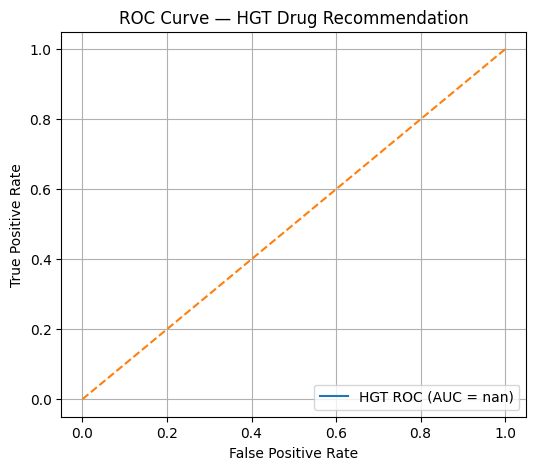

In [79]:
y_true, y_score = collect_predictions(val_loader, max_batches=500)

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"HGT ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — HGT Drug Recommendation")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


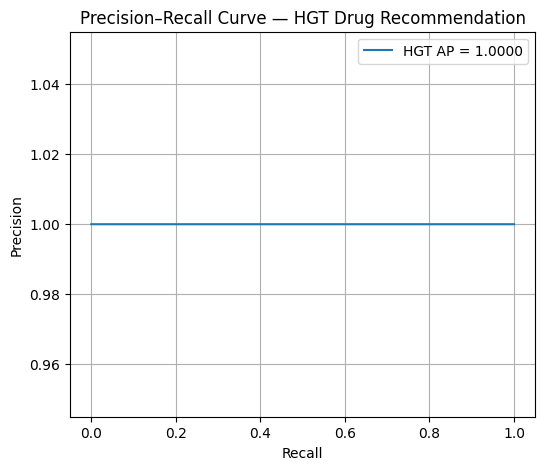

In [80]:
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"HGT AP = {ap:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — HGT Drug Recommendation")
plt.legend()
plt.grid(True)
plt.show()


In [82]:
recall_5 = recall_at_k_drug_only_safe(
    model,
    data,
    drug_concept_indices,
    k=5,
    max_patients=50
)

recall_10 = recall_at_k_drug_only_safe(
    model,
    data,
    drug_concept_indices,
    k=10,
    max_patients=50
)

print("FINAL HGT Recall@5 :", recall_5)
print("FINAL HGT Recall@10:", recall_10)


/usr/local/lib/python3.12/dist-packages/torch_geometric/loader/link_neighbor_loader.py:252: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(


Processed 10/50 patients
Processed 20/50 patients
Processed 30/50 patients
Processed 40/50 patients
Processed 50/50 patients
Processed 10/50 patients
Processed 20/50 patients
Processed 30/50 patients
Processed 40/50 patients
Processed 50/50 patients
FINAL HGT Recall@5 : 0.1711864219618449
FINAL HGT Recall@10: 0.17524364632980277


In [83]:
del model
torch.cuda.empty_cache()
gc.collect()


3924

In [84]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv


In [85]:
class RGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, metadata, data):
        super().__init__()

        self.node_types = metadata[0]
        self.edge_types = metadata[1]

        # Initial per-node-type projection
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in self.node_types:
            in_channels = data[node_type].x.size(-1)
            self.lin_dict[node_type] = torch.nn.Linear(
                in_channels, hidden_channels
            )

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                RGCNConv(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    num_relations=len(self.edge_types)
                )
            )

    def forward(self, x_dict, edge_index_dict):
        # Project node features
        x_dict = {
            k: self.lin_dict[k](v)
            for k, v in x_dict.items()
        }

        # Convert hetero graph → homogeneous
        x, edge_index, edge_type = self._to_homo(
            x_dict, edge_index_dict
        )

        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(x)

        # Split back to dict
        out_dict = {}
        start = 0
        for k, v in x_dict.items():
            out_dict[k] = x[start:start + v.size(0)]
            start += v.size(0)

        return out_dict

    def _to_homo(self, x_dict, edge_index_dict):
        x_all = []
        node_offset = {}
        offset = 0

        for k, v in x_dict.items():
            x_all.append(v)
            node_offset[k] = offset
            offset += v.size(0)

        x_all = torch.cat(x_all, dim=0)

        edge_indices = []
        edge_types = []

        for rel_id, (src, rel, dst) in enumerate(self.edge_types):
            edge_index = edge_index_dict[(src, rel, dst)]
            edge_indices.append(
                edge_index + torch.tensor(
                    [[node_offset[src]], [node_offset[dst]]],
                    device=edge_index.device
                )
            )
            edge_types.append(
                torch.full(
                    (edge_index.size(1),),
                    rel_id,
                    device=edge_index.device,
                    dtype=torch.long
                )
            )

        edge_index = torch.cat(edge_indices, dim=1)
        edge_type = torch.cat(edge_types, dim=0)

        return x_all, edge_index, edge_type


In [86]:
class RGCNLinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels, metadata, data):
        super().__init__()
        self.encoder = RGCN(
            hidden_channels=hidden_channels,
            num_layers=2,
            metadata=metadata,
            data=data
        )

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        src, dst = edge_label_index
        return (z_dict['patient'][src] *
                z_dict['concept'][dst]).sum(dim=1)


In [87]:
rgcn_model = RGCNLinkPredictor(
    hidden_channels=64,
    metadata=data.metadata(),
    data=data
).to(device)

rgcn_optimizer = torch.optim.Adam(
    rgcn_model.parameters(), lr=0.001
)

print("R-GCN model initialized on", device)


R-GCN model initialized on cuda


In [88]:
def train_rgcn(epoch, max_batches=None):
    rgcn_model.train()
    total_loss = 0.0
    start = time.time()

    for step, batch in enumerate(train_loader, start=1):
        batch = batch.to(device)
        rgcn_optimizer.zero_grad()

        pred = rgcn_model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        )

        target = batch['patient','prescribed','concept'].edge_label.float()
        loss = F.binary_cross_entropy_with_logits(pred, target)
        loss.backward()
        rgcn_optimizer.step()

        total_loss += loss.item()

        if step % 10 == 0:
            print(
                f"[R-GCN] Epoch {epoch} | "
                f"Batch {step}/{len(train_loader)} | "
                f"Loss {loss.item():.4f} | "
                f"Elapsed {time.time() - start:.1f}s"
            )

        if max_batches and step >= max_batches:
            break

    return total_loss / step


In [89]:
@torch.no_grad()
def test_rgcn(loader, max_batches=None):
    rgcn_model.eval()
    preds, targets = [], []

    for step, batch in enumerate(loader, start=1):
        batch = batch.to(device)

        out = rgcn_model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        ).sigmoid()

        preds.append(out.cpu())
        targets.append(
            batch['patient','prescribed','concept'].edge_label.cpu()
        )

        if max_batches and step >= max_batches:
            break

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    if len(np.unique(targets)) < 2:
        return float("nan")

    return roc_auc_score(targets, preds)


In [90]:
print(" Starting R-GCN debug run")

for epoch in range(1, 3):
    loss = train_rgcn(epoch, max_batches=200)
    train_auc = test_rgcn(train_loader, max_batches=50)
    val_auc   = test_rgcn(val_loader,   max_batches=50)

    print(
        f"[R-GCN] Epoch {epoch} DONE | "
        f"Loss {loss:.4f} | "
        f"Train AUC {train_auc:.4f} | "
        f"Val AUC {val_auc:.4f}"
    )


 Starting R-GCN debug run
[R-GCN] Epoch 1 | Batch 10/38509 | Loss 0.7449 | Elapsed 3.5s
[R-GCN] Epoch 1 | Batch 20/38509 | Loss 0.6481 | Elapsed 5.2s
[R-GCN] Epoch 1 | Batch 30/38509 | Loss 0.5609 | Elapsed 7.0s
[R-GCN] Epoch 1 | Batch 40/38509 | Loss 0.4890 | Elapsed 8.7s
[R-GCN] Epoch 1 | Batch 50/38509 | Loss 0.4037 | Elapsed 10.4s
[R-GCN] Epoch 1 | Batch 60/38509 | Loss 0.3951 | Elapsed 12.2s
[R-GCN] Epoch 1 | Batch 70/38509 | Loss 0.3846 | Elapsed 13.9s
[R-GCN] Epoch 1 | Batch 80/38509 | Loss 0.3703 | Elapsed 15.7s
[R-GCN] Epoch 1 | Batch 90/38509 | Loss 0.3682 | Elapsed 17.4s
[R-GCN] Epoch 1 | Batch 100/38509 | Loss 0.3708 | Elapsed 19.2s
[R-GCN] Epoch 1 | Batch 110/38509 | Loss 0.3718 | Elapsed 21.0s
[R-GCN] Epoch 1 | Batch 120/38509 | Loss 0.3958 | Elapsed 22.7s
[R-GCN] Epoch 1 | Batch 130/38509 | Loss 0.3652 | Elapsed 24.4s
[R-GCN] Epoch 1 | Batch 140/38509 | Loss 0.3678 | Elapsed 26.2s
[R-GCN] Epoch 1 | Batch 150/38509 | Loss 0.3696 | Elapsed 27.9s
[R-GCN] Epoch 1 | Batch 160

In [ ]:
print(" Starting FULL R-GCN training")

for epoch in range(1, 3):
    loss = train_rgcn(epoch)
    val_auc = test_rgcn(val_loader, max_batches=500)

    print(
        f"[R-GCN] Epoch {epoch} COMPLETE | "
        f"Loss {loss:.4f} | "
        f"Val AUC {val_auc:.4f}"
    )


 Starting FULL R-GCN training
[R-GCN] Epoch 1 | Batch 10/38509 | Loss 0.3538 | Elapsed 3.4s
[R-GCN] Epoch 1 | Batch 20/38509 | Loss 0.4017 | Elapsed 5.1s
[R-GCN] Epoch 1 | Batch 30/38509 | Loss 0.3352 | Elapsed 6.9s
[R-GCN] Epoch 1 | Batch 40/38509 | Loss 0.3539 | Elapsed 8.6s
[R-GCN] Epoch 1 | Batch 50/38509 | Loss 0.3509 | Elapsed 10.4s
[R-GCN] Epoch 1 | Batch 60/38509 | Loss 0.3566 | Elapsed 12.1s
[R-GCN] Epoch 1 | Batch 70/38509 | Loss 0.3517 | Elapsed 13.8s
[R-GCN] Epoch 1 | Batch 80/38509 | Loss 0.3573 | Elapsed 15.5s
[R-GCN] Epoch 1 | Batch 90/38509 | Loss 0.3038 | Elapsed 17.3s
[R-GCN] Epoch 1 | Batch 100/38509 | Loss 0.3380 | Elapsed 19.0s
[R-GCN] Epoch 1 | Batch 110/38509 | Loss 0.3503 | Elapsed 20.7s
[R-GCN] Epoch 1 | Batch 120/38509 | Loss 0.3855 | Elapsed 22.4s
[R-GCN] Epoch 1 | Batch 130/38509 | Loss 0.3371 | Elapsed 24.1s
[R-GCN] Epoch 1 | Batch 140/38509 | Loss 0.3713 | Elapsed 25.9s
[R-GCN] Epoch 1 | Batch 150/38509 | Loss 0.3596 | Elapsed 27.7s
[R-GCN] Epoch 1 | Batch

In [ ]:
rgcn_model.eval()
for p in rgcn_model.parameters():
    p.requires_grad = False

print("R-GCN model frozen")


In [ ]:
RGCN_MODEL_PATH = "/kaggle/working/rgcn_drug_recommender.pt"

torch.save(
    {
        "model_state_dict": rgcn_model.state_dict(),
        "metadata": data.metadata(),
        "hidden_channels": 64,
        "num_layers": 2,
        "model_type": "RGCN",
    },
    RGCN_MODEL_PATH
)

print("R-GCN model saved to", RGCN_MODEL_PATH)


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch

@torch.no_grad()
def collect_predictions_rgcn(loader, max_batches=None):
    rgcn_model.eval()
    all_preds = []
    all_labels = []

    for step, batch in enumerate(loader, start=1):
        batch = batch.to(device)

        logits = rgcn_model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['patient','prescribed','concept'].edge_label_index
        )

        probs = logits.sigmoid()

        all_preds.append(probs.cpu())
        all_labels.append(
            batch['patient','prescribed','concept'].edge_label.cpu()
        )

        if max_batches and step >= max_batches:
            break

    y_score = torch.cat(all_preds).numpy()
    y_true  = torch.cat(all_labels).numpy()

    return y_true, y_score


In [ ]:
y_true_rgcn, y_score_rgcn = collect_predictions_rgcn(
    val_loader, max_batches=500
)

fpr, tpr, _ = roc_curve(y_true_rgcn, y_score_rgcn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"R-GCN ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — R-GCN Drug Recommendation")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
precision, recall, _ = precision_recall_curve(
    y_true_rgcn, y_score_rgcn
)
ap = average_precision_score(y_true_rgcn, y_score_rgcn)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"R-GCN AP = {ap:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — R-GCN Drug Recommendation")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
epochs = range(1, len(rgcn_train_losses) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, rgcn_train_losses, marker='o', label="Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch — R-GCN")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(epochs, rgcn_train_aucs, marker='o', label="Train AUC")
plt.plot(epochs, rgcn_val_aucs, marker='o', label="Validation AUC")

plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC vs Epoch — R-GCN")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
K_values = list(range(1, 51))

recalls_rgcn, precisions_rgcn = recall_precision_at_k_curve_rgcn(
    rgcn_model,
    train_data,
    patient_to_true_drugs,
    drug_concept_indices,
    K_values,
    max_patients=300
)

plt.figure(figsize=(7, 5))
plt.plot(K_values, recalls_rgcn, label="Recall@K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.title("Recall@K Curve — R-GCN (Drug-only)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(K_values, precisions_rgcn, label="Precision@K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.title("Precision@K Curve — R-GCN (Drug-only)")
plt.grid(True)
plt.legend()
plt.show()
